In [1]:
import pandas as pd
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import math

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [3]:
%matplotlib inline

In [4]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [5]:
def readFile(filename):
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.")
    print(df_1.shape)
    df_1 = df_1.sort()
    print("=====Total Personal Income File=====")
    return df_1

In [6]:
df_MD = readFile("MD_TotalPersonalIncome.csv")

File read into dataframe.
(39, 1)
=====Total Personal Income File=====


In [7]:
df_MD.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [8]:
df_MD.head()

,MD_Total Personal Income
1977-01-01,35682.8
1978-01-01,39666.4
1979-01-01,43606.6
1980-01-01,48538.9
1981-01-01,53951.9


In [9]:
df_MD.rename(columns={'MD_Total Personal Income': 'MD_TotalPersonalIncome'}, inplace=True)

In [10]:
df_MD.MD_TotalPersonalIncome.describe()

count        39.000000
mean     165891.400000
std       94434.207956
min       35682.800000
25%       84895.700000
50%      143275.400000
75%      250237.750000
max      337174.100000
Name: MD_TotalPersonalIncome, dtype: float64

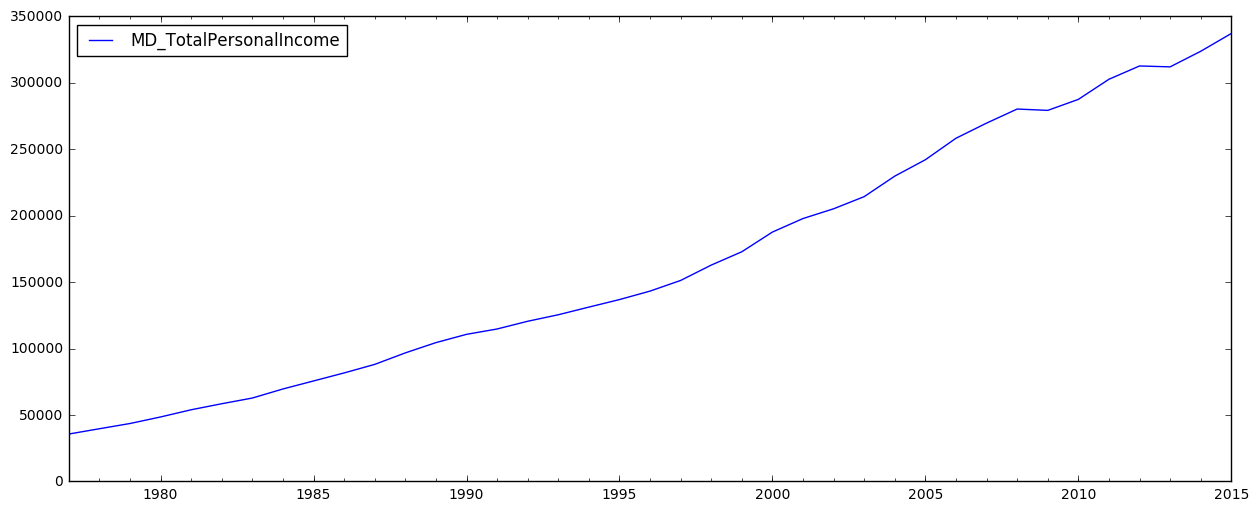

In [11]:
df_MD.plot(figsize=(15,6))
plt.show()
#fig.savefig('DC_TotalPersonalIncome.png', dpi=150)

There is an overall increasing trend in the data.

In [12]:
#Further Decompose time-series into trend, seasionality and noise
def decompose(df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive')
    fig = decomposition.plot()
    plt.show()
    #fig.savefig('Seasonal_Decompose.png', dpi=150)

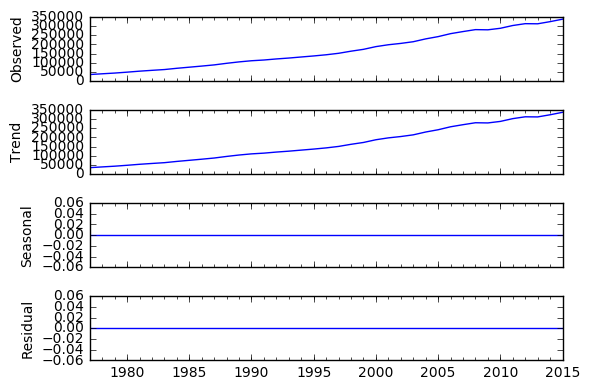

In [13]:
decompose(df_MD)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not.
First, check the mean and variance.
Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [14]:
#Split the dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [15]:
meanVarianceCheck(df_MD)

('mean1=84138.357895, mean2=243556.790000',
 'variance1=1043016446.731911, variance2=3571696974.185899')

In [16]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

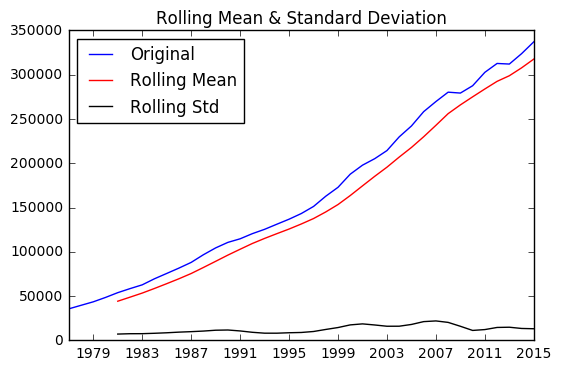

Results of Dickey-Fuller Test:
Test Statistic                  1.347179
p-value                         0.996860
#Lags Used                     10.000000
Number of Observations Used    28.000000
Critical Value (5%)            -2.971989
Critical Value (1%)            -3.688926
Critical Value (10%)           -2.625296
dtype: float64


In [17]:
test_stationarity(df_MD.MD_TotalPersonalIncome)

# Estimating & Eliminating Trend

In [18]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

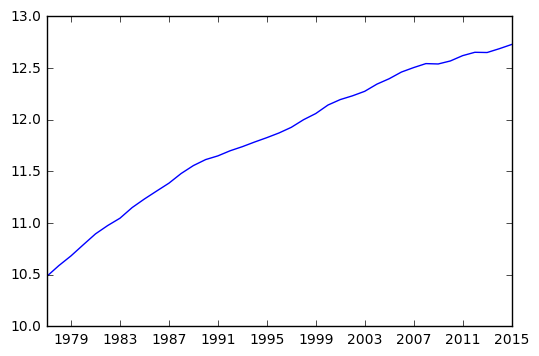

In [19]:
ts_log = logTransform(df_MD)

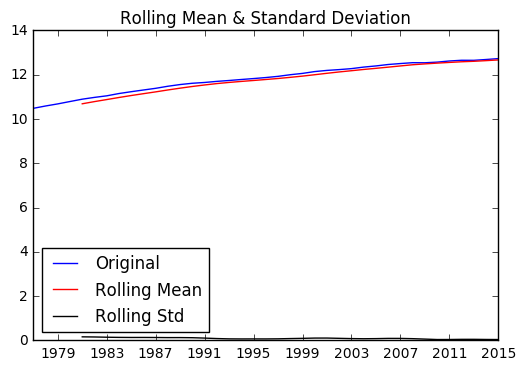

Results of Dickey-Fuller Test:
Test Statistic                 -1.514105
p-value                         0.526523
#Lags Used                     10.000000
Number of Observations Used    28.000000
Critical Value (5%)            -2.971989
Critical Value (1%)            -3.688926
Critical Value (10%)           -2.625296
dtype: float64


In [20]:
test_stationarity(ts_log.MD_TotalPersonalIncome)

In [21]:
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

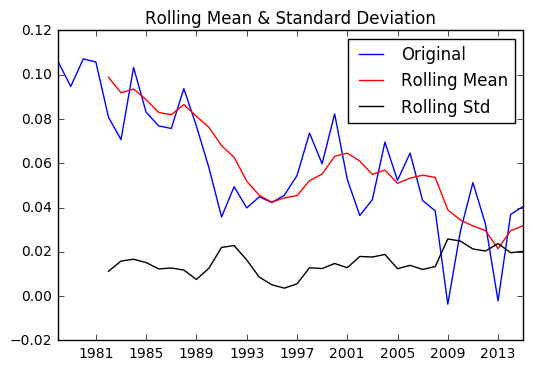

Results of Dickey-Fuller Test:
Test Statistic                 -1.442352
p-value                         0.561812
#Lags Used                      9.000000
Number of Observations Used    28.000000
Critical Value (5%)            -2.971989
Critical Value (1%)            -3.688926
Critical Value (10%)           -2.625296
dtype: float64


In [22]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.MD_TotalPersonalIncome)

In [23]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

In [24]:
ts_first_diff = firstDifference(df_MD)

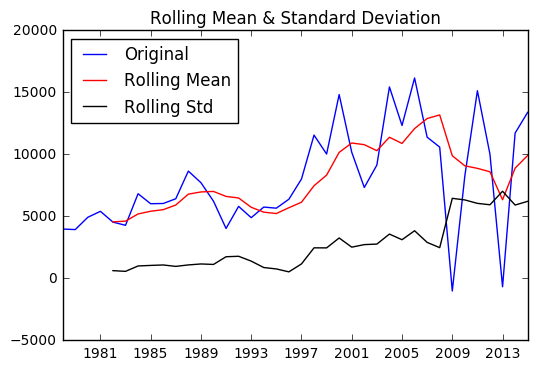

Results of Dickey-Fuller Test:
Test Statistic                 -0.861681
p-value                         0.800330
#Lags Used                      9.000000
Number of Observations Used    28.000000
Critical Value (5%)            -2.971989
Critical Value (1%)            -3.688926
Critical Value (10%)           -2.625296
dtype: float64


In [25]:
test_stationarity(ts_first_diff.MD_TotalPersonalIncome)

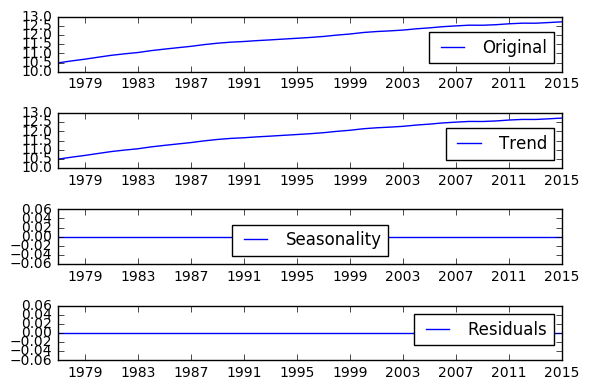

In [26]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

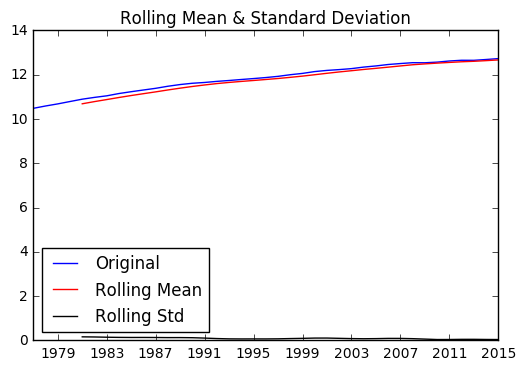

Results of Dickey-Fuller Test:
Test Statistic                 -1.514105
p-value                         0.526523
#Lags Used                     10.000000
Number of Observations Used    28.000000
Critical Value (5%)            -2.971989
Critical Value (1%)            -3.688926
Critical Value (10%)           -2.625296
dtype: float64


In [27]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.MD_TotalPersonalIncome)

# Forecasting a Time Series

In [30]:
lag_acf = acf(ts_log, nlags=5)
lag_pacf = pacf(ts_log, nlags=5, method='ols')

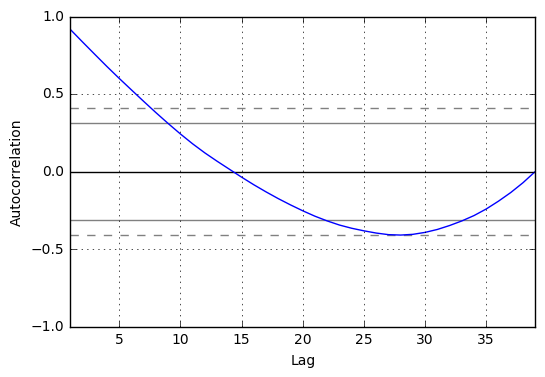

In [31]:
autocorrelation_plot(ts_log)

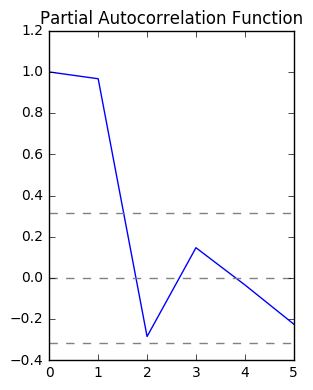

In [32]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [37]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [38]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [39]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    plt.plot(ts_log)
    plt.plot(results_AR.fittedvalues, color='red')
    return results_AR

Lag: 2
Coefficients: const                           11.343158
ar.L1.MD_TotalPersonalIncome     1.952329
ar.L2.MD_TotalPersonalIncome    -0.954415
dtype: float64
                                ARMA Model Results                                
Dep. Variable:     MD_TotalPersonalIncome   No. Observations:                   39
Model:                         ARMA(2, 0)   Log Likelihood                  92.270
Method:                           css-mle   S.D. of innovations              0.020
Date:                    Thu, 27 Apr 2017   AIC                           -176.541
Time:                            16:54:15   BIC                           -169.886
Sample:                        01-01-1977   HQIC                          -174.153
                             - 01-01-2015                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

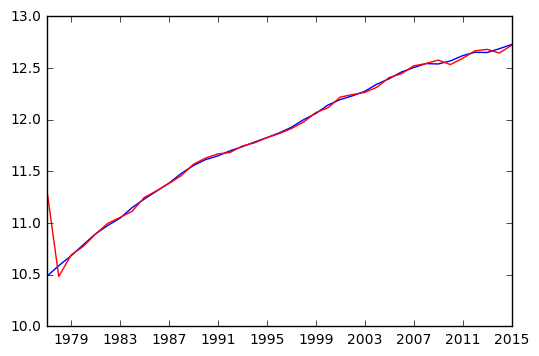

In [40]:
model_AR = AR_Model(ts_log)

In [41]:
def MA_Model(ts):
    model = ARIMA(ts, order=(0, 0, 7))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 7))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts_log)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                           11.788572
ma.L1.MD_TotalPersonalIncome     3.012159
ma.L2.MD_TotalPersonalIncome     5.267713
ma.L3.MD_TotalPersonalIncome     6.561766
ma.L4.MD_TotalPersonalIncome     6.451819
ma.L5.MD_TotalPersonalIncome     4.860007
ma.L6.MD_TotalPersonalIncome     2.611342
ma.L7.MD_TotalPersonalIncome     0.695940
dtype: float64
                                ARMA Model Results                                
Dep. Variable:     MD_TotalPersonalIncome   No. Observations:                   39
Model:                         ARMA(0, 7)   Log Likelihood                  66.626
Method:                           css-mle   S.D. of innovations              0.034
Date:                    Thu, 27 Apr 2017   AIC                           -115.253
Time:                            16:55:06   BIC                           -100.281
Sample:                        01-01-1977   HQIC                          -109.881
                             - 01-01-2015      

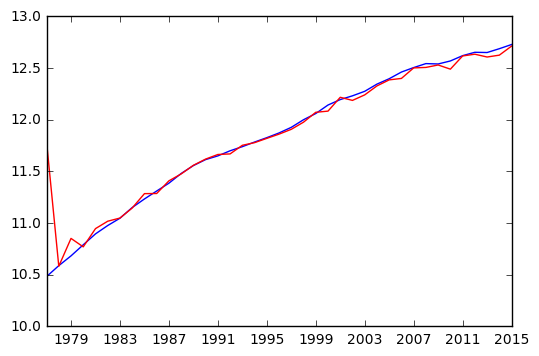

In [42]:
model_MA = MA_Model(ts_log)

In [63]:
def Combined_Model(ts):
    model = ARIMA(ts_log, order=(5, 0, 5))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(5, 0, 5))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts_log)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

In [65]:
#model_Combined = Combined_Model(ts_log)

In [66]:
aic_metric

,AIC,Modelname
0,-176.540712,"ARIMA(ts, order=(2, 0, 0))"
0,-115.252752,"ARIMA(ts, order=(0, 0, 7))"


In [67]:
aic_dict

{'ARIMA(ts, order=(0, 0, 7))': -115.2527517614298,
 'ARIMA(ts, order=(2, 0, 0))': -176.54071157643367}

In [68]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(2, 0, 0))


In [69]:
#Forecast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output 

In [71]:
output_forecast = forecast(model_AR,5)

[ 349464.5973901   360541.81128548  370317.54567124  378724.19667271
  385715.26169771]
